# Klasyfikacja kolektywna

## Dane nie-IID

Klasyczne metody uczenia maszynowego zakładają spełnienie warunku IID (ang. *Independent and Identically Distributed*), co oznacza, że dane są niezależne i pochodzą z tego samego rozkładu.

Systemy złożone często jednak nie spełniają tego warunku. W sieciach społecznych może występować korelacja zachowań między jednostkami, która jest wynikiem działania dwóch mechanizmów:
- homofilii - osoby tworzą więzi z osobami podobnymi w pewien sposób do nich samych
- wpływu społecznego - więzi społeczne mogą wpływać na charakterystykę jednostki

Standardowe metody klasyfikacji mogą sobie nie poradzić z relacyjnym charakterem danych, a także nie wykorzystać jego potencjału. W przypadku pracy z danymi nie-IID możemy jednak wykorzystać metody klasyfikacji kolektywnej, które nie mają ograniczeń klasycznych metod klasyfikacji.

## Ogólny schemat klasyfikacji kolektywnej

Istnieje wiele algorytmów klasyfikacji kolektywnej, jednak dla nich wszystkich możemy wyróżnić wspólny zestaw kroków uczenia w systemach nie-IID:
1. Zbudowanie nieoetykietowanej sieci.
2. Obliczenie oceny użyteczności węzłów (*utility score*). Najczęściej używa się miar sieciowych (np. betweenness), które zostały opisane w dalszej części.
3. Zbudowanie rankingu węzłów na podstawie oceny użyteczności.
4. Wybór najlepszych węzłów i odsłonięcie ich etykiet. W tym momencie otrzymujemy sieć częściowo oetykietowaną.
5. Przeprowadzenie wewnątrzsieciowej klasyfikacji w oparciu o wybrany algorytm klasyfikacji kolektywnej.
6. Otrzymanie etykiet nieznanych węzłów.

![cc](data/collective_classification/cc.png)

## Dwa popularne algorytmy:

### Iterative Classification Algorithm (ICA) 

[ICA]((https://www.aaai.org/Papers/Workshops/2000/WS-00-06/WS00-06-007.pdf)) jest algorytmem iteracyjnym, którego działanie możemy opisać w dwóch fazach:
1. **Faza bootstrapingu**
    - Wytrenuj lokalny klasyfikator na znanych węzłach, które zostały odsłonięte.
    - Dokonaj predykcji etykiet nieznanych węzłów w oparciu o wyuczony lokalny klasyfikator.
2. **Faza klasyfikacji iteracyjnej** - aż do osiągnięcia warunku stopu
    - Wygeneruj porządek dla nieznanych węzłów (inny niż utility score).
    - W oparciu o wygenerowany porządek dla każdego nieznanego węzła:
        - Oblicz cechy bazujące na sąsiadach
        - Dokonaj predykcji etykiety węzła z wykorzystaniem lokalnego klasyfikatora i zaktualizowanych cech


### Loopy Belief Propagation (LBP)

[LBP](https://arxiv.org/abs/1301.6725), podobnie jak ICA, jest również algorytmem iteracyjnym, jednakże zamiast lokalnego klasyfikatora wykorzystuje przekazywanie wiadomości między węzłami.

Główne kroki algorytmu to:
1. Przypisanie wszystkim nieznanym węzłom takiej samej wiadomości (np. m = 1).
2. Faza message passing aż do osiągnięcia warunku stopu:
![lbp](data/collective_classification/lbp.png)
![lbp2](data/collective_classification/lbp2.png)
3. Obliczenie przekonań węzłów:
![lbp3](data/collective_classification/lbp3.png)


**Notacja:**
- label-label potential $\psi(Y_i,Y_j)$ - zależność proporcjonalna do prawdopodobieństwa, że węzeł $j$ ma etykietę $Y_j$ wiedząc, że jego sąsiadem jest węzeł $i$ mający etykietę $Y_i$
- prior $\phi(Y_i)$ - przekonanie proporcjonalne do prawdopodobieństwa, że węzeł $i$ należy do klasy $Y_i$
- $m_{i \rightarrow j}(Y_j)$ - wiadomość z węzła $i$ do $j$, że węzeł $j$ należy do klasy $Y_j$
- $\mathcal{L}$ - zbiór wszystkich klas

# Przykład zastosowania algorytmu ICA

## Zbiór danych

W prezentowanym przykładzie będziemy wykorzystywali zbiór [manufacturing company](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6Z3CGX) zawierający komunikację mailową pracowników pewnej polskiej firmy wytwórczej. 

W zbiorze dostępne są również informacje o strukturze organizacyjnej firmy, która wygląda w następujący sposób:
1. Regularni pracownicy
2. Pracownicy pierwszego poziomu zarządzania
3. Pracownicy drugiego poziomu zarządzania.

Naszym celem będzie pokazanie, w jaki sposób można wykorzystać algorytm ICA do odtworzenia struktury organizacyjnej, mając do dyspozycji tylko sieć zbudowaną na podstawie komunikacji mailowej pracowników oraz częściową wiedzę na temat zajmowanych przez nich stanowisk.

Będziemy chcieli rozróżnić 2 klasy: regularnych pracowników oraz kadrę zarządzającą (pierwszy i drugi stopień traktujemy jako jedną klasę)

Plik `reportsto.csv` zawiera informację na temat tego, który pracownik (`ID`) raportuje któremu pracownikowi (`ReportsToID`).

In [3]:
if (!require('tidyverse')) install.packages('tidyverse')


# Wczytanie danych i usunięcie kont niebędących pracownikami
reportsto <- read.csv2("data/collective_classification/reportsto.csv")
toRemove <- c("former employee account", "technical email account - not used by employees")
reportsto <- reportsto %>% filter(!(ReportsToID %in% toRemove))

head(reportsto)

,ID,ReportsToID
,<int>,<chr>
1,1,152
2,2,132
3,3,152
4,5,36
5,6,163
6,7,86


In [4]:
# ID pracowników pierwszego stopnia zarządzania
first_management_level <- c(76, 90, 136, 137, 143, 152, 47, 162)

# ID pracowników drugiego stopnia zarządzania
second_management_level <- c(86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163)

management_level <- c(first_management_level, second_management_level)

# Pozostałe ID to regularni pracownicy

Plik `communication.csv` zawiera informację o komunikacji mailowej pracowników.

In [5]:
communication <- read.csv2("data/collective_classification/communication.csv")
communication <- communication %>% filter(Sender %in% reportsto$ID & Recipient %in% reportsto$ID)

head(communication)

,Sender,Recipient,EventDate
,<int>,<int>,<chr>
1,17,37,2010-01-02 17:40:10
2,17,136,2010-01-02 17:40:10
3,17,62,2010-01-02 17:40:10
4,17,129,2010-01-02 17:40:10
5,17,32,2010-01-02 17:40:10
6,17,97,2010-01-02 17:40:10


## Budowa sieci

Do zbudowania grafu, a następnie do obliczenia miar sieciowych wykorzystamy pakiet `igraph`.

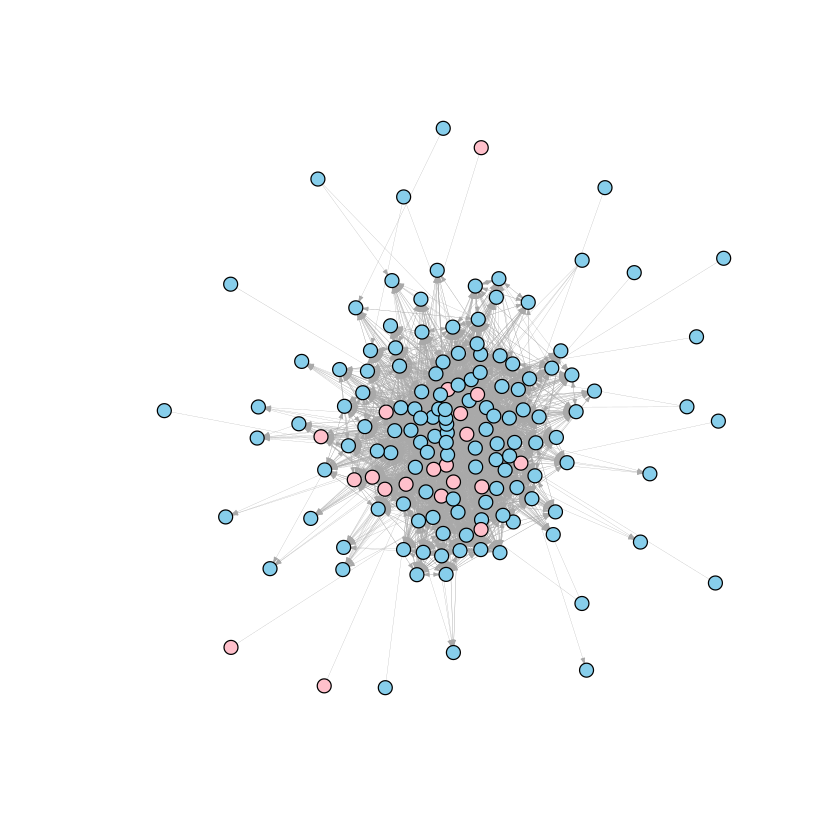

In [6]:
if (!require('igraph')) install.packages('igraph')

# Tworzymy graf skierowany na podstawie historii komunikacji mailowej
g <- graph_from_data_frame(communication, directed = TRUE)

# Każdej krawędzi przypisujemy wagę 1
E(g)$weight <- 1

# Upraszczamy graf:
#  - usuwamy pętle
#  - zastępujemy powtarzające się krawędzie poprzez zsumowanie wag i przypisanie ich do pojedynczej krawędzi
g <- simplify(g, remove.loops = TRUE, remove.multiple = TRUE, edge.attr.comb=list(weight="sum"))

# Przypisanie hierarchii. Regularni pracownicy są oznaczeni przez cyfrę 1, a kadra zarządzająca przez cyfrę 2
g <- set_vertex_attr(g, name = "true_label", value = 1)
g <- set_vertex_attr(g, name = "true_label", value = 2, index = V(g)[V(g)$name %in% management_level])

# Wizualizacja sieci
g <- set_vertex_attr(g, name = "color", value = c("pink", "skyblue")[1+(V(g)$true_label==1)])
plot(g, layout = layout_with_lgl(g), vertex.label = NA, vertex.size = 5, edge.width = 0.2, edge.arrow.size = 0.2)

## Obliczenie cech węzłów - miary sieciowe

Kolejnym krokiem po zbudowaniu sieci jest obliczenie miar opisujących ważność każdego węzła w sieci.

### Centralność stopnia węzła (ang. *degree centrality*)
Najprostszą miarą jest stopień każdego węzła. Ważne węzły będą miały więcej krawędzi łączących je z innymi węzłami. Stopień węzła może być użyty do zdefiniowania miary zwanej centralnością stopnia (ang. *degree centrality*).

$$C_{deg}(v) = \dfrac{d_v}{N-1}$$

gdzie $v$ to dany węzeł, $d_v$ to liczba krawędzi danego węzła $v$, $N$ jest całkowitą liczbą węzłów w sieci.

In [7]:
degree_centrality <- degree(g, normalized = TRUE, mode = "all")
g <- set_vertex_attr(g, name = "degree", value = degree_centrality)

### Bliskość (ang. *closeness*)
Bliskość przypisuje wyższy wynik tym węzłom, które mają mniejszą odległość do wszystkich pozostałych węzłów w sieci. Miarę tę można zdefiniować jako:

$$C_c(v) = \dfrac{n-1}{N-1}\dfrac{n-1}{\sum_{u=1}^{n-1}\sigma_{v,u}}$$

gdzie $n$ jest liczbą węzłów, do których można się dostać z węzła $v$, $N$ jest całkowitą liczbą węzłów w sieci, $\sigma_{v,u}$ jest długością najkrótszej ścieżki między węzłami $v$ i $u$.

In [8]:
closeness_centrality <- closeness(g, normalized = TRUE , mode = "all")
g <- set_vertex_attr(g, name = "closeness", value = closeness_centrality)

### Pośredniość (ang. *betweenness*)
Pośredniość między węzłami jest miarą wykorzystującą najkrótsze ścieżki do obliczenia ważności każdego węzła. Miarę tę można obliczyć według następującego wzoru:

$$C_{B}(v) = \sum_{s,t\in V}\dfrac{\sigma_{s,t}(v)}{\sigma_{s,t}}$$

In [9]:
betweenness_centrality <- betweenness(g, directed = TRUE, normalized = TRUE)
g <- set_vertex_attr(g, name = "betweenness", value = betweenness_centrality)

## Budowanie rankingu

Jednym z problemów klasyfikacji kolektywnej jest wybór węzłów, które zostaną odkryte, a następnie użyte w procesie klasyfikacji kolektywnej. Głównym celem jest taki nieprzypadkowy wybór węzłów, aby zminimalizować błąd klasyfikacji.

W celu skwantyfikowania użyteczności danego węzła możemy użyć różnych miar sieciowych, jakie dostarcza nam obliczeniowa nauka o sieciach. Należy wybrać jedną z wcześniej wspomnianych miar (np. betweenness), obliczyć ją dla każdego węzła, a następnie posegregować węzły rosnąco lub malejąco według wybranej miary.

Mając zbudowany ranking odsłaniamy $p\%$ etykiet najlepszych węzłów ($V^K$). Posłużą one do wytrenowania lokalnego klasyfikatora.

Pozostałe węzły traktujemy jako nieznane ($V^{UK}$).

Na potrzeby tego przykładu użyjemy miary betweenness jako oceny użyteczności oraz odsłonimy 60% węzłów w sieci.

In [10]:
betweenness_centrality <- data.frame(name = V(g)$name, value = betweenness_centrality, label=V(g)$true_label, 
                                     stringsAsFactors = FALSE)

node_order <- betweenness_centrality[order(betweenness_centrality$value, decreasing = TRUE),]

p <- 0.6

known_nodes <- node_order[1:round(p*nrow(node_order)),]
unknown_nodes <- node_order %>% filter(!(name %in% known_nodes$name))

g <- set_vertex_attr(g, name = "pred_label", value = V(g)$true_label)
g <- set_vertex_attr(g, name = "pred_label", index = V(g)[V(g)$name %in% unknown_nodes$name], value = 0)

## Trenowanie prostego klasyfikatora lokalnego

Mając już odsłonięte węzły, musimy ich użyć do wytrenowania prostego lokalnego klasyfikatora. W tym celu możemy użyć dobrze znanych modeli takich jak Naive Bayes, SVM, drzewo decyzyjne lub las losowy.

Jako cech wejściowych dla algorytmu klasyfikacji użyjemy wcześniej obliczonych miar sieciowych: degree centrality, closeness i betweenness. Jako dodatkowych cech użyjemy informacji na temat tego ilu sąsiadów danego węzła należy do klasy 1 (regularni pracownicy) , a ilu do klasy 2 (pracownicy pierwszego lub drugiego poziomu zarządzania).

Poniżej użyliśmy algorytmu lasu losowego z 5-krotną walidacją krzyżową.

In [15]:
if (!require('caret')) install.packages('caret')
if (!require('MLmetrics')) install.packages('MLmetrics')

update_neighbors <- function(g, nodes) {
  for (i in 1:nrow(nodes)) {
    neighborhood <- neighbors(g, v = nodes[i,]$name, mode = "all")
    
    neighbors_1 <- 0
    neighbors_2 <- 0
    
    for (n in 1:length(neighborhood)) {
      label <- vertex_attr(g, index = neighborhood[n])$pred_label

      if (label == 1) {
        neighbors_1 <- neighbors_1 + 1
      } else if (label == 2){
        neighbors_2 = neighbors_2 + 1
      }
    }
    
    g <- set_vertex_attr(g, name = "neighbors_1", index = nodes[i,]$name, value = neighbors_1)
    g <- set_vertex_attr(g, name = "neighbors_2", index = nodes[i,]$name, value = neighbors_2)
  }
  return(g)
}

F1_Macro <- function(data, lev = NULL, model = NULL) {
  f1_scores <- sapply(lev, function(l) {
    f1_score <- MLmetrics::F1_Score(y_pred = data$pred, y_true = data$obs, positive = l)
    if(is.na(f1_score)) {
      f1_score <- 0
    }
    return(f1_score)
  })
  macro <- sum(f1_scores) / length(lev)
  return(c(macro=macro, class=f1_scores))
}

# Oblicz cechy bazujące na sąsiadach
g <- update_neighbors(g, known_nodes)

# Trenowanie klasyfikatora
attributes <- vertex_attr(g, index = known_nodes$name)
trainingData <- data.frame(attributes$betweenness, attributes$closeness, attributes$degree, 
                       attributes$neighbors_1, attributes$neighbors_2,
                       label = as.factor(attributes$true_label))

fitControl <- trainControl(method = "CV", number = 5, summaryFunction = F1_Macro, search = "random")
classifier <- train(label ~ ., data = trainingData, method = "rf", trControl = fitControl, 
                    preProcess = c("center", "scale"), metric = "macro", tuneLength=10)

## Bootstrapping
W fazie bootstrapingu przypisujemy klasę nieznanym węzłom $V^{UK}$ tylko na podstawie zaobserwowanych węzłów $V^K$. 

In [16]:
# Zaktualizuj informację na temat liczby sąsiadów (należących do V^K)
g <- update_neighbors(g, unknown_nodes)

# Użyj lokalnego klasyfikatora do przypisania klasy węzłom należącym do V^UK
for (n in 1:nrow(unknown_nodes)) {
    node <- unknown_nodes[n,]$name
    
    attributes <- vertex_attr(g, index = node)
    
    testData <- data.frame(attributes$betweenness, attributes$closeness, attributes$degree, 
                       attributes$neighbors_1, attributes$neighbors_2)
    
    predicted_label <- predict(classifier, newdata = testData)
    g <- set_vertex_attr(g, name = "pred_label", index = node, value = predicted_label)
  }

## Iteracyjna klasyfikacja

W fazie iteracyjnej klasyfikacji przechodzimy po nieznanych węzłach $V^{UK}$ wykonując następujące kroki dla każdego węzła $v$:
1. Zaktualizuj informacje o sąsiadach $N_v$.
2. Użyj lokalnego klasyfikatora oraz informacji z poprzedniego kroku do predykcji etykiety węzła $v$.
3. Czy osiągnięto warunek stopu? TAK - koniec, NIE - wróć do punktu 1.

Warunek stopu jest osiągnięty, jeżeli etykiety węzłów ustabilizują się w kolejnych iteracjach lub gdy zostanie wykonana maksymalna liczba iteracji.

In [16]:
i <- 1
maxIter <- 100
changed <- TRUE

while (i <= maxIter & changed) {
  changed <- FALSE
  
  unknown_nodes <- unknown_nodes[sample(nrow(unknown_nodes)),]
  
  for (n in 1:nrow(unknown_nodes)) {
    node <- unknown_nodes[n,]$name
    
    # Zaktualizuj informacje o sąsiadach węzła n na podstawie aktualnie przypisanych etykiet
    g <- update_neighbors(g, unknown_nodes[n,])
    
    attributes <- vertex_attr(g, index = node)
    
    test <- data.frame(attributes$betweenness, attributes$closeness, attributes$degree, 
                       attributes$neighbors_1, attributes$neighbors_2)
    
    # Predykcja nowej etykiety
    predicted_label <- predict(classifier, newdata = test)
    current_label <- attributes$pred_label
    
    # Jeżeli nowa etykieta jest różna od obecnej, to przypisujemy ją do węzła
    if (predicted_label != current_label) {
      g <- set_vertex_attr(g, name = "pred_label", index = node, value = predicted_label)
      changed <- TRUE
    }
  }
  
  i <- i + 1
}

## Ewaluacja modelu

Do ewaluacji modelu klasyfikacji kolektywnej możemy użyć tych samych miar co w przypadku zwykłych algorytmów klasyfikacji, np.: `accuracy` lub `F1`.

W naszym przykładzie użyliśmy miary `F1 macro`, będącą średnią miary F1 dla każdej z klas. Dodatkowo możemy zauważyć, że miara F1 dla klasy 2 (stopień zarządzający) jest niższa, co spowodowane jest niezbalansowaniem klas.

W celu polepszenia otrzymanego wyniku należałoby przetestować różne miary sieciowe do oceny użyteczności węzłów oraz zastanowić się, jakie jeszcze cechy węzłów mogą być użyteczne przy określeniu hierarchii organizacyjnej.

In [17]:
true_labels = vertex_attr(g, name="true_label", index = V(g)[V(g)$name %in% unknown_nodes$name])
pred_labels = vertex_attr(g, name="pred_label", index = V(g)[V(g)$name %in% unknown_nodes$name])

F1_Macro(data.frame("pred"=pred_labels, "obs"=true_labels), lev = c(1,2))

macro    class1    class2 
0.7324561 0.9649123 0.5000000

## Rekomendowana literatura

1. [Neville, Jennifer, and David Jensen. "Iterative classification in relational data." Proc. AAAI-2000 workshop on learning statistical models from relational data. 2000.](https://www.aaai.org/Papers/Workshops/2000/WS-00-06/WS00-06-007.pdf)
2. [Murphy, Kevin, Yair Weiss, and Michael I. Jordan. "Loopy belief propagation for approximate inference: An empirical study." arXiv preprint arXiv:1301.6725 (2013).](https://arxiv.org/abs/1301.6725)
3. [Sen, Prithviraj, et al. "Collective classification in network data." AI magazine 29.3 (2008): 93-93.](https://ojs.aaai.org/index.php/aimagazine/article/view/2157)
4. [Kajdanowicz, Tomasz, et al. "Learning in unlabeled networks–An active learning and inference approach." AI Communications 29.1 (2016): 123-148.](https://content.iospress.com/articles/ai-communications/aic686)
5. [Stanford CS224W Message Passing and Node Classification](http://snap.stanford.edu/class/cs224w-2020/slides/05-message.pdf)